In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


# Задача

В данном задании вам предлагается решить задачу извлечения аргументов (объектов, аспектов и предикатов) из предложения. Такая модель должна быть обучена на предложениях, где слова или фразы имеют разметку последовательности – каждому слову соответствует его тег.

> **Пример.** Postgres is easier to install and maintain than Oracle.
>
> [Postgres **OBJECT**] is [easier **PREDICATE**] to [install **ASPECT**] and [maintain **ASPECT**] than [Oracle **OBJECT**].

> Сущности могут состоять из нескольких слов: Advil works better for body aches and pains than Motrin.
>
> [Advil **OBJECT**] works [better **PREDICATE**] for [body aches **ASPECT**] and [pains **ASPECT**] than [Motrin **OBJECT**].

Данные состоят из сравнительных предложений (т.е. предложений, содержащих сравнение двух или более объектов). В предложениях содержится следующая информация:

-	*Объекты* – объекты, которые сравниваются
-	*Аспекты* – характеристики, по которым сравниваются объекты
-	*Сказуемое* – слова или фразы, которые реализуют сравнение (обычно сравнительные прилагательные или наречия)

В наборе данных используется схема BIO:

- Первое слово сущности помечается тегом `B-<entity-type>` (начало сущности).
- Второе и последующие слова сущности помечаются тегом `I-<entity-type>` (внутри сущности).
- Слова, которые не являются частью сущности, помечаются тегом `O` (вне сущности).

Поэтому в нашем наборе данных используются следующие метки:
- O
- B-Object
- I-Object
- B-Aspect
- I-Aspect
- B-Predicate
- I-Predicate

**Ваша задача** – присвоить одну из таких меток каждому токену данных путем обучения модели на основе LSTM.


# Data loading

In [3]:
def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long, device=device)

In [4]:
def read_dataset(filename, splitter="\t"):
    data = []
    sentence = []
    tags = []
    with open(filename) as f:
        for line in f:
            if not line.isspace():
                word, tag = line.split(splitter)
                sentence.append(word)
                tags.append(tag.strip())
            else:
                data.append((sentence, tags))
                sentence = []
                tags = []
    return data

In [5]:
!gdown 1wkfEJCUKF5nbZ6lV6HlRtcEaNkLrLo7y

Downloading...
From: https://drive.google.com/uc?id=1wkfEJCUKF5nbZ6lV6HlRtcEaNkLrLo7y
To: /content/train.tsv
100% 599k/599k [00:00<00:00, 8.50MB/s]


In [6]:
!gdown 10kS7glt0sLoh6UIn0RtpREW-zcU_zIay

Downloading...
From: https://drive.google.com/uc?id=10kS7glt0sLoh6UIn0RtpREW-zcU_zIay
To: /content/test_no_answer.tsv
100% 43.1k/43.1k [00:00<00:00, 94.2MB/s]


In [7]:
training_data = read_dataset("train.tsv")

In [53]:
training_data[0]

(['also',
  ',',
  'i',
  'have',
  'recently',
  'discovered',
  'advil',
  'liquigels',
  'work',
  'much',
  'better',
  'and',
  'faster',
  'for',
  'a',
  'headache',
  'than',
  'regular',
  'ibuprofen',
  '.'],
 ['O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B-Object',
  'O',
  'O',
  'O',
  'B-Predicate',
  'O',
  'B-Predicate',
  'O',
  'O',
  'B-Aspect',
  'O',
  'O',
  'B-Object',
  'O'])

In [9]:
test_data = read_dataset("test_no_answer.tsv", splitter="\n")

In [10]:
test_data[0]

(['meanwhile',
  ',',
  'though',
  'windows',
  '8',
  'is',
  'significantly',
  'at',
  'greater',
  'risk',
  '(',
  '1',
  '.',
  '73',
  'percent',
  ')',
  'compared',
  'to',
  'windows',
  '8',
  '.',
  '1',
  ',',
  'according',
  'to',
  'redmond',
  "'",
  's',
  'report',
  ',',
  'it',
  "'",
  's',
  'still',
  'significantly',
  'safer',
  'than',
  'windows',
  '7',
  ',',
  'windows',
  'xp',
  ',',
  'or',
  'windows',
  'vista',
  '.'],
 ['',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  ''])

In [11]:
word_to_ix = {}

# For each words-list (sentence) and tags-list in each tuple of training_data
for sent, tags in training_data:
    for word in sent:
        if word not in word_to_ix:  # word has not been assigned an index yet
            word_to_ix[word] = len(word_to_ix)  # Assign each word with a unique index

for sent, tags in test_data:
    for word in sent:
        if word not in word_to_ix:  # word has not been assigned an index yet
            word_to_ix[word] = len(word_to_ix)  # Assign each word with a unique index


tag_to_ix = {
    "O": 0,
    "B-Object": 1,
    "I-Object": 2,
    "B-Aspect": 3,
    "I-Aspect": 4,
    "B-Predicate": 5,
    "I-Predicate": 6
}  # Assign each tag with a unique index

idx_to_tag = dict(map(reversed, tag_to_ix.items()))

In [12]:
for X, y in training_data:
    print(X, y)
    break

['also', ',', 'i', 'have', 'recently', 'discovered', 'advil', 'liquigels', 'work', 'much', 'better', 'and', 'faster', 'for', 'a', 'headache', 'than', 'regular', 'ibuprofen', '.'] ['O', 'O', 'O', 'O', 'O', 'O', 'B-Object', 'O', 'O', 'O', 'B-Predicate', 'O', 'B-Predicate', 'O', 'O', 'B-Aspect', 'O', 'O', 'B-Object', 'O']


# Tagger

Опишите архитектуру нейросети. Все необходимые слои описаны в комментариях. В качестве выхода из модели используйте логистический softmax:

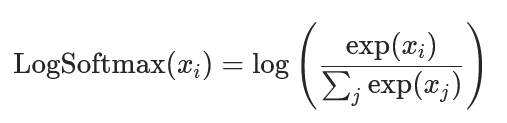

In [72]:
class LSTMTagger(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(LSTMTagger, self).__init__()
        torch.manual_seed(5)
        torch.cuda.manual_seed(5)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        self.hidden_dim = hidden_dim

        # The Embedding layer with size of the dictionary vocab_size
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)

        # The linear layer that maps from hidden state space to tag space
        self.linear = nn.Linear(hidden_dim, tagset_size)

        # Log-Softmax activation for tag scores
        self.log_softmax = nn.LogSoftmax(dim=2)  # Apply across tag classes

    def forward(self, sentence):
        embeddings = self.word_embeddings(sentence)

        lstm_out, _ = self.lstm(embeddings)
        tag_space = self.linear(lstm_out)

        tag_scores = self.log_softmax(tag_space)
        return tag_scores


# Training

Обучите модель с представленными ниже параметрами.

In [73]:
EMBEDDING_DIM = 32
HIDDEN_DIM = 64

model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix), len(tag_to_ix))
model = model.to(device)

loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

 10%|█         | 1/10 [00:04<00:36,  4.08s/it]

 Epoch 1 train loss: 0.608


 20%|██        | 2/10 [00:08<00:34,  4.36s/it]

 Epoch 2 train loss: 0.400


 30%|███       | 3/10 [00:12<00:29,  4.21s/it]

 Epoch 3 train loss: 0.333


 40%|████      | 4/10 [00:16<00:24,  4.15s/it]

 Epoch 4 train loss: 0.297


 50%|█████     | 5/10 [00:21<00:21,  4.30s/it]

 Epoch 5 train loss: 0.272


 60%|██████    | 6/10 [00:25<00:16,  4.20s/it]

 Epoch 6 train loss: 0.252


 70%|███████   | 7/10 [00:29<00:12,  4.13s/it]

 Epoch 7 train loss: 0.235


 80%|████████  | 8/10 [00:33<00:08,  4.28s/it]

 Epoch 8 train loss: 0.219


 90%|█████████ | 9/10 [00:37<00:04,  4.21s/it]

 Epoch 9 train loss: 0.205


100%|██████████| 10/10 [00:41<00:00,  4.20s/it]

 Epoch 10 train loss: 0.192


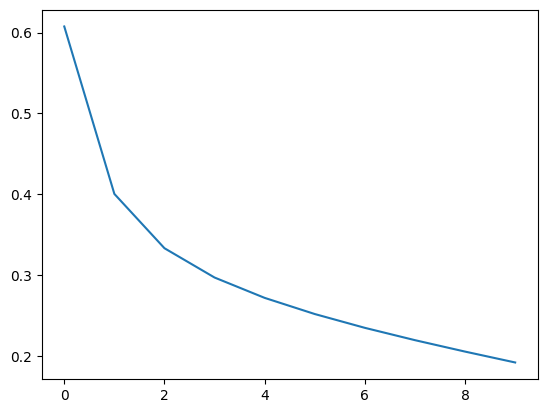

In [74]:
history = []
n_epoch = 10

for epoch in tqdm(range(n_epoch)):
    train_loss = 0
    for X, y in training_data:
        tensor_X = prepare_sequence(X, word_to_ix)
        tensor_y = prepare_sequence(y, tag_to_ix)

        optimizer.zero_grad()

        predicts = model(tensor_X.unsqueeze(0))  # Add batch dimension

        # Reshape outputs  for NLLLoss
        predicts = predicts.view(-1, len(tag_to_ix))

        loss = loss_function(predicts, tensor_y)
        train_loss += loss.item()

        loss.backward()
        optimizer.step()

    # Average loss for the epoch
    epoch_loss = train_loss / len(training_data)
    history.append(epoch_loss)
    print(f" Epoch {epoch + 1} train loss: {epoch_loss:.3f}")

plt.plot(np.arange(n_epoch), history)
plt.show()


# Inference
Предскажите метки для слов из первого предложения.

In [75]:
with torch.no_grad():
    sentence_to_predict = prepare_sequence(test_data[0][0], word_to_ix)
    tag_scores = model(sentence_to_predict.unsqueeze(0)).view(-1, len(tag_to_ix))
    for i in range(len(test_data[0][0])):
        print(test_data[0][0][i], "->", [idx_to_tag[int(i)] for i in tag_scores.argmax(dim=-1)][i])

meanwhile -> O
, -> O
though -> O
windows -> O
8 -> O
is -> O
significantly -> O
at -> O
greater -> B-Predicate
risk -> O
( -> O
1 -> O
. -> O
73 -> O
percent -> O
) -> O
compared -> O
to -> O
windows -> O
8 -> O
. -> O
1 -> O
, -> O
according -> O
to -> O
redmond -> O
' -> O
s -> O
report -> O
, -> O
it -> O
' -> O
s -> O
still -> O
significantly -> O
safer -> B-Predicate
than -> O
windows -> O
7 -> O
, -> O
windows -> O
xp -> O
, -> O
or -> O
windows -> O
vista -> O
. -> O


Предскажите метки для слов из десятого предложения.

In [76]:
with torch.no_grad():
    sentence_to_predict = prepare_sequence(test_data[10][0], word_to_ix)
    tag_scores = model(sentence_to_predict.unsqueeze(0)).view(-1, len(tag_to_ix))
    for i in range(len(test_data[10][0])):
        print(test_data[10][0][i], "->", [idx_to_tag[int(i)] for i in tag_scores.argmax(dim=-1)][i])

but -> O
that -> O
aside -> O
, -> O
windows -> O
10 -> O
is -> O
still -> O
easier -> B-Predicate
to -> O
navigate -> B-Aspect
than -> O
mac -> B-Object
os -> O
x -> O
and -> O
windows -> O
8 -> O
, -> O
has -> O
better -> B-Predicate
access -> B-Aspect
to -> O
files -> O
than -> O
in -> O
android -> O
, -> O
and -> O
is -> O
faster -> B-Predicate
, -> O
more -> B-Predicate
flexible -> I-Predicate
and -> O
more -> B-Predicate
capable -> B-Aspect
than -> O
windows -> O
xp -> O
and -> O
the -> O
home -> O
and -> O
enterprise -> O
editions -> O
of -> O
windows -> O
7 -> O
. -> O


Предскажите метки для слов из сотого предложения.

In [77]:
with torch.no_grad():
    sentence_to_predict = prepare_sequence(test_data[100][0], word_to_ix)
    tag_scores = model(sentence_to_predict.unsqueeze(0)).view(-1, len(tag_to_ix))
    c = 0
    for i in range(len(test_data[100][0])):
        pred = [idx_to_tag[int(i)] for i in tag_scores.argmax(dim=-1)][i]
        print(test_data[100][0][i], "->", pred)
        if pred == "O":
            c+=1
    print(c)

fyi -> O
- -> O
i -> O
like -> O
my -> O
ipad -> O
but -> O
usually -> O
only -> O
use -> O
it -> O
when -> O
i -> O
' -> O
m -> O
traveling -> O
since -> O
its -> O
so -> O
much -> O
lighter -> B-Predicate
to -> O
carry -> B-Aspect
around -> O
than -> O
a -> O
laptop -> O
and -> O
way -> O
easier -> B-Predicate
to -> O
read -> B-Aspect
than -> O
my -> O
phone -> O
. -> O
32


Сохраните результаты предсказания на тестовом наборе (`test_data`) в файл, запустив код ниже.

In [78]:
with open("out_test.tsv", "w") as w:
    with torch.no_grad():
        for sentence in tqdm(test_data):
            inputs = prepare_sequence(sentence[0], word_to_ix)
            tag_scores = model(inputs.unsqueeze(0)).view(-1, len(tag_to_ix))
            tags = [idx_to_tag[int(i)] for i in tag_scores.argmax(dim=-1)]
            for i, y in zip(sentence[0], tags):
                w.write(f"{i}\t{y}\n")
            w.write("\n")

100%|██████████| 283/283 [00:00<00:00, 1154.25it/s]


Файл `test.tsv` содержит разметку тестовых данных. Сравните файлы построчно, запустив код ниже. Сколько суммарно меток было предсказано верно (то есть сколько строк совпало)?

In [46]:
!gdown 1mUtlDtb7naXDi1U8x73UdyncnHv1BOjd

Downloading...
From: https://drive.google.com/uc?id=1mUtlDtb7naXDi1U8x73UdyncnHv1BOjd
To: /content/test.tsv
100% 81.1k/81.1k [00:00<00:00, 3.48MB/s]


In [79]:
points = 0
with open("test.tsv", "r") as f_eval, open("out_test.tsv", "r") as f:
  for line_eval, line in zip(f_eval.readlines(), f.readlines()):
    if line_eval == line: points += 1
print(points)

7375
